# Knn Regression

1. Choose K (the number of clusters you want).

2. Initialize K centroids randomly.

3. Repeat until convergence:
   a. Assign each data point to the nearest centroid.
   b. Recalculate the centroids based on the current assignment of data points.
   
4. Return the final K centroids and the corresponding cluster assignments.


In [502]:
# import modules 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline 

In [503]:
df = pd.read_csv('../cleaning-preprocessing/cleaned_flight_data_with_target.csv')
# df.head(5)

In [504]:
df = df.astype(int)
# df.head(5)

In [516]:
X = df.drop(columns=['DEP_DELAY'])  # Feature matrix
y = df['DEP_DELAY']  # Target variable

y.head(10)

0    0
1    0
2    1
3    0
4    0
5    0
6    0
7    0
8    0
9    0
Name: DEP_DELAY, dtype: int64

### Feature Selection

In [506]:
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import StandardScaler

# Standardize numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply SelectKBest with f_regression
k = 15  # Number of top features to select
selector = SelectKBest(score_func=f_regression, k=k)
X_selected = selector.fit_transform(X_scaled, y)

# Get selected feature names
selected_features = X.columns[selector.get_support()]
feature_scores = selector.scores_[selector.get_support()]

# Create a DataFrame with feature names and scores
feature_df = pd.DataFrame({'Feature': selected_features, 'F-Score': feature_scores})
feature_df = feature_df.sort_values(by='F-Score', ascending=False)

# Print the selected features
print("Selected Features:")
print(feature_df)
# print(feature_df['Feature'])


Selected Features:
                         Feature     F-Score
3                      CRS_DEP_M  463.142591
5                     Wind Speed  184.319216
9           OP_UNIQUE_CARRIER_B6  124.931998
0                          MONTH  119.431576
7                       Pressure   85.771770
14                Condition_Rain   67.707229
6                      Wind Gust   52.436444
10                      DEST_LAX   52.009222
4                      CRS_ARR_M   48.745415
12  Condition_Light Snow / Windy   47.229615
1                   DAY_OF_MONTH   39.283694
13       Condition_Mostly Cloudy   34.231628
11          Condition_Heavy Rain   32.373246
2               CRS_ELAPSED_TIME   30.335697
8                        sch_dep   30.205092


In [507]:
from sklearn.model_selection import train_test_split 
X_train, X_test, y_train, y_test = train_test_split(X[feature_df['Feature']], y, test_size = 0.25, random_state = 0)

In [508]:
X_train

,CRS_DEP_M,Wind Speed,OP_UNIQUE_CARRIER_B6,MONTH,Pressure,Condition_Rain,Wind Gust,DEST_LAX,CRS_ARR_M,Condition_Light Snow / Windy,DAY_OF_MONTH,Condition_Mostly Cloudy,Condition_Heavy Rain,CRS_ELAPSED_TIME,sch_dep
5823,1077,9,1,11,29,0,18,0,1279,0,18,0,0,382,35
897,1375,12,1,11,30,0,0,0,18,0,3,0,0,83,21
2739,899,10,1,11,30,0,0,0,1050,0,9,0,0,211,26
6162,1035,12,0,11,29,0,0,0,1259,0,19,0,0,404,30
2503,1125,22,0,11,30,0,30,0,1282,0,8,0,0,157,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13123,420,5,0,12,30,0,0,0,565,0,13,0,0,205,19
19648,525,8,0,1,29,0,0,0,671,0,3,0,0,146,54
9845,515,13,0,12,29,0,0,0,807,0,1,0,0,232,53
10799,580,15,0,12,29,0,0,0,675,0,5,1,0,95,32


In [509]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [510]:
from sklearn.neighbors import KNeighborsRegressor
# weights='distance'
regressor = KNeighborsRegressor(n_neighbors=19, metric='manhattan')
regressor.fit(X_train, y_train)

KNeighborsRegressor(metric='manhattan', n_neighbors=19)

In [511]:
y_pred = regressor.predict(X_test)

In [512]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("\nModel Performance Metrics:")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"R-Squared (R2): {r2:.4f}")


Model Performance Metrics:
Mean Squared Error (MSE): 0.11
Mean Absolute Error (MAE): 0.20
R-Squared (R2): 0.0868


In [513]:
# from sklearn.model_selection import GridSearchCV

# param_grid = {'n_neighbors': range(3, 21, 2)}
# grid = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='r2')
# grid.fit(X_train, y_train)
# print("Best k:", grid.best_params_)

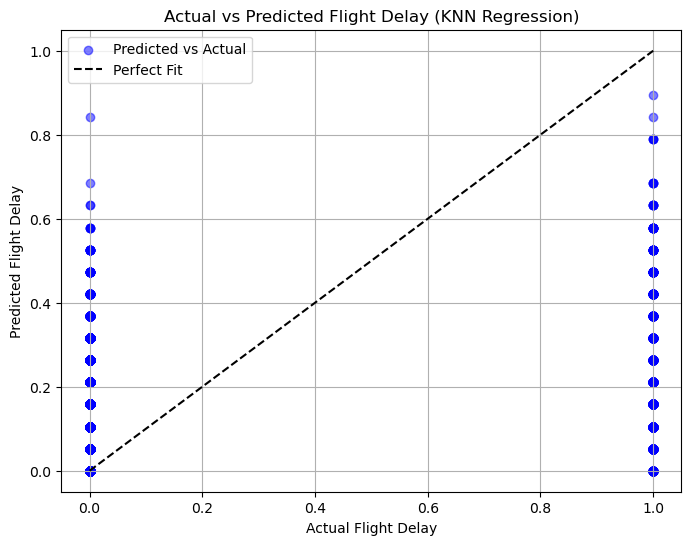

In [514]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.5, label="Predicted vs Actual")
plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='black', linestyle='--', label="Perfect Fit")

plt.xlabel("Actual Flight Delay")
plt.ylabel("Predicted Flight Delay")
plt.title("Actual vs Predicted Flight Delay (KNN Regression)")
plt.legend()
plt.grid(True)
plt.show()